### Imports:

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import importlib
from datetime import datetime

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from keras.models import Model
from keras.layers import Dense, SimpleRNN, RNN
from keras import backend as K
import keras.regularizers
import keras.optimizers

### Imports locales:

- data_generation: para generar los datos del problema.

In [3]:
import sys
sys.path.insert(1, '/kaggle/input/tfg-rnn/')
import data_generation_v3 as data_generation

### Recarga de los módulos:

In [4]:
importlib.reload(data_generation)

<module 'data_generation_v3' from '/kaggle/input/tfg-rnn/data_generation_v3.py'>

### Función para cargar los datos de Tomita:

In [5]:
def load_data(fname_x, fname_y, batch_size, seq_len):
  with open(fname_x, 'r') as f:
    datos_x = f.read()
  with open(fname_y, 'r') as f:
    datos_y = f.read()

  longitud = len(datos_x) // batch_size
  qx = [datos_x[i*longitud:(i+1)*longitud] for i in range(batch_size)]
  qy = [datos_y[i*longitud:(i+1)*longitud] for i in range(batch_size)]

  # Empiezo cada cadena de qx en el primer $:
  aqx = []
  aqy = []
  for ax, ay in zip(qx, qy):
    i = ax.find("$")
    aqx.append(ax[i:])
    aqy.append(ay[i:])  

  qx = aqx
  qy = aqy

  xs_one_hot, ys_one_hot, xs_sparse, ys_sparse, xs_symbols, ys_symbols = data_generation.get_data_from_strings(qx, qy, seq_len)

  return xs_one_hot, ys_one_hot, xs_sparse, ys_sparse, xs_symbols, ys_symbols

### Carga de los datos de entrenamiento:


In [6]:
num_tomita = 1
batch_size = 32
seq_len = 25

fx = '/kaggle/input/tfg-rnn/train/tomita%dnueva_train_x.txt' % num_tomita
fy = '/kaggle/input/tfg-rnn/train/tomita%dnueva_train_y.txt' % num_tomita

xs_one_hot, ys_one_hot, xs_sparse, ys_sparse, xs_symbols, ys_symbols = load_data(fx, fy, batch_size, seq_len)
char_to_ix = {s: i for i, s in enumerate(xs_symbols)}
ix_to_char = {i: s for i, s in enumerate(xs_symbols)}
print(xs_one_hot.shape)
print(ys_one_hot.shape)

(1920, 25, 3)
(1920, 25, 2)


### Carga de los datos de test:

In [7]:
batch_size_test = 1

fx = '/kaggle/input/tfg-rnn/test/tomita%dnueva_testGrande_x.txt' % num_tomita
fy = '/kaggle/input/tfg-rnn/test/tomita%dnueva_testGrande_y.txt' % num_tomita

xs_one_hot_test, ys_one_hot_test, xs_sparse_test, ys_sparse_test, xs_symbols_test, ys_symbols_test = load_data(fx, fy, batch_size_test, seq_len)
print(xs_one_hot_test.shape)
print(ys_one_hot_test.shape)

(4000, 25, 3)
(4000, 25, 2)


### Función para copiar los pesos de una red a otra:

In [8]:
def copy_weights(source_model, dest_model):
  for source_layer, dest_layer in zip(source_model.layers, dest_model.layers):
    dest_layer.set_weights(source_layer.get_weights())

### Clase para implementar las células recurrentes de entrenamiento y de test:

In [9]:
class SampleRNNCell(keras.layers.Layer):

    def __init__(self, nunits, train, **kwargs):
        self.nunits = nunits
        self.train = train
        self.state_size = tf.TensorShape([nunits])
        super(SampleRNNCell, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({'nunits': self.nunits, 'train': self.train})
        return config
    
    def build(self, input_shape):
        self.Wxh = self.add_weight(shape=(input_shape[-1], self.nunits),
                                   initializer='uniform',
                                   name='kernel')
        self.Whh = self.add_weight(shape=(self.nunits, self.nunits),
                                   initializer='uniform',
                                   name='recurrent_kernel')
        self.b = self.add_weight(shape=(self.nunits,),
                                 initializer='uniform',
                                 name='bias')
        self.built = True

    def call(self, inputs, states):
        h_prev = states[0]
        x = inputs
        logits = keras.backend.dot(x, self.Wxh) + keras.backend.dot(h_prev, self.Whh) + self.b
        z = tf.math.sigmoid(logits)
        if self.train:
            h = tf.cast(tf.random.uniform(z.shape) < z, dtype=tf.float32)
        else:
            h = tf.cast(0.5 < z, dtype=tf.float32)
        return [logits, h], [h]

### Función para crear el modelo:

In [10]:
def create_model(nunits, batch_size, seq_len, input_dim, output_dim, train):

    inputs = keras.Input(batch_shape=(batch_size, seq_len, input_dim))
    logits, h = RNN(SampleRNNCell(nunits, train), return_sequences=True, stateful=True)(inputs)
    y = Dense(output_dim, activation='softmax')(h)
    model = keras.Model(inputs=inputs, outputs=[logits, h, y])

    return model

### Función para entrenar el modelo, donde además se guardan los pesos del modelo y se le aplica el testeo cada 1000 épocas:

In [11]:
def train_model(model, num_epochs, x, y, batch_size):

  optimizer_dense = tf.keras.optimizers.Nadam()
  optimizer_rnn = tf.keras.optimizers.Nadam()
  model_loss = np.zeros(num_epochs)
  model_accuracy = np.zeros(num_epochs)

  for epoch in range(num_epochs):
    epoch_loss = []
    epoch_accuracy = []
    model.reset_states()
    for i in range(0, x.shape[0], batch_size):
      batch_x = x[i:i+batch_size, :, :]
      y_true = y[i:i+batch_size, :, :]
      with tf.GradientTape(persistent=True) as tape:
        # Calcula la pérdida de la capa de salida
        logits, h, y_pred = model(batch_x)
        loss_dense = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        loss_dense_mean = tf.math.reduce_mean(loss_dense)

        # Calcula el reward asociado a la pérdida
        r = -loss_dense.numpy().mean(axis=1) # promedio en secuencia, no en batch
        r -= np.mean(r)
        r /= np.std(r)
        r = r[:, None]
        # Calcula la pérdida de las capas ocultas
        loss_rnn = tf.keras.losses.binary_crossentropy(h, logits, from_logits=True) * r
        loss_rnn_mean = tf.math.reduce_mean(loss_rnn)
        variables_rnn = model.trainable_variables[:3]
        variables_dense = model.trainable_variables[3:]

        # Calcula la pérdida total y obtiene los gradientes
        grads_dense = tape.gradient(loss_dense_mean, variables_dense)
        grads_rnn = tape.gradient(loss_rnn_mean, variables_rnn)

        # Aplica los gradientes al modelo
        optimizer_dense.apply_gradients(zip(grads_dense, variables_dense))
        optimizer_rnn.apply_gradients(zip(grads_rnn, variables_rnn))
                                      
        epoch_loss.append(loss_dense_mean.numpy())

        # Calcula precisión
        predictions = np.argmax(y_pred.numpy(), axis=2)
        classes = np.argmax(y_true, axis=2)
        epoch_accuracy.append(np.mean(predictions == classes))
    model_loss[epoch] = np.array(epoch_loss).mean()
    model_accuracy[epoch] = np.array(epoch_accuracy).mean()

    print("\rTraining epoch: %d / %d" % (epoch+1, num_epochs), end="")
    print(", loss = %f, acc = %f" % (model_loss[epoch], model_accuracy[epoch]))

    if (epoch + 1) % 1000 == 0:
      now = datetime.now()
      filename = '/kaggle/working/tomita%d_%d_%s.h5' % (num_tomita, epoch, now.strftime("%Y%m%d%H"))
      model.save(filename)
    
      model_test = create_model(nunits, batch_size_test, seq_len, x.shape[2], y.shape[2], False)
      copy_weights(model, model_test)
      model_test_loss, model_test_acc = test_model(model_test, xs_one_hot_test, ys_one_hot_test, batch_size_test)
      print("Test: loss = %f, acc = %f" % (model_test_loss, model_test_acc))

  return model_loss, model_accuracy

### Función para evaluar el modelo:

In [12]:
def test_model(model, x, y, batch_size):

  model.reset_states()
  mean_loss = []
  mean_accuracy = []
  for i in range(0, x.shape[0], batch_size):
    batch_x = x[i:i+batch_size, :, :]
    y_true = y[i:i+batch_size, :, :]

    _, _, y_pred = model(batch_x)
    loss_dense = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    loss_dense_mean = tf.math.reduce_mean(loss_dense)
    mean_loss.append(loss_dense_mean)

    predictions = np.argmax(y_pred.numpy(), axis=2)
    classes = np.argmax(y_true, axis=2)
    mean_accuracy.append(np.mean(predictions == classes))
  
  return np.array(mean_loss).mean(), np.array(mean_accuracy).mean()

### Ejecuciones y sus gráficas:

In [13]:
nunits = 20
input_dim = xs_one_hot.shape[2]
output_dim = ys_one_hot.shape[2]
num_epochs = 1000

K.clear_session()
model = create_model(nunits, batch_size, seq_len, input_dim, output_dim, True)
model_loss_train, model_accuracy_train = train_model(model, num_epochs, xs_one_hot, ys_one_hot, batch_size)

Training epoch: 1 / 1000, loss = 0.923755, acc = 0.409271
Training epoch: 2 / 1000, loss = 0.571226, acc = 0.724042
Training epoch: 3 / 1000, loss = 0.513633, acc = 0.790500
Training epoch: 4 / 1000, loss = 0.505101, acc = 0.803708
Training epoch: 5 / 1000, loss = 0.500266, acc = 0.806896
Training epoch: 6 / 1000, loss = 0.495842, acc = 0.809708
Training epoch: 7 / 1000, loss = 0.491420, acc = 0.811938
Training epoch: 8 / 1000, loss = 0.486226, acc = 0.813542
Training epoch: 9 / 1000, loss = 0.485746, acc = 0.813667
Training epoch: 10 / 1000, loss = 0.482386, acc = 0.815187
Training epoch: 11 / 1000, loss = 0.476802, acc = 0.816229
Training epoch: 12 / 1000, loss = 0.477841, acc = 0.816375
Training epoch: 13 / 1000, loss = 0.472713, acc = 0.816792
Training epoch: 14 / 1000, loss = 0.472540, acc = 0.817667
Training epoch: 15 / 1000, loss = 0.470207, acc = 0.817458
Training epoch: 16 / 1000, loss = 0.468586, acc = 0.817917
Training epoch: 17 / 1000, loss = 0.466720, acc = 0.817563
Traini

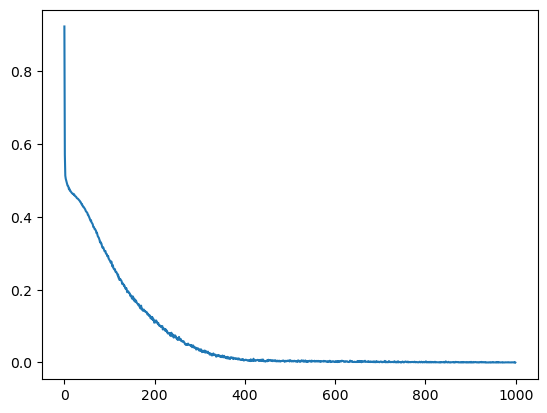

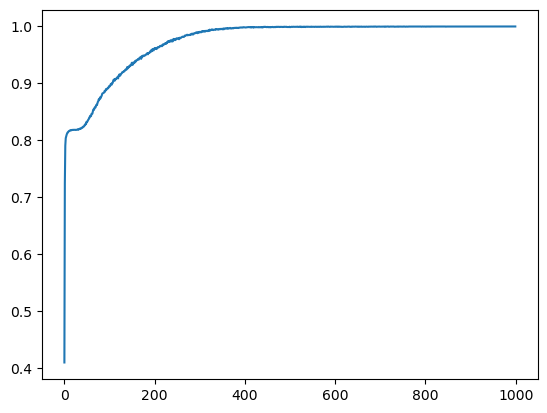

In [14]:
plt.plot(model_loss_train)
plt.show()
plt.plot(model_accuracy_train)
plt.show()

### Recordatorio de cómo cargar un modelo:

In [15]:
#model3 = keras.models.load_model('/kaggle/working/tomita7_20230228160549.h5', custom_objects={'SampleRNNCell': SampleRNNCell})
#model3.summary()